In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
mnist_data = datasets.MNIST(root="./data",train=True,download=True,transform=trans)
data_loadr =  torch.utils.data.DataLoader(mnist_data,batch_size=64,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# delet folder
# %rm -rf data

In [ ]:
dataiter = iter(data_loadr)
images,labels = next(dataiter)
labels #it will print 64 labels because of the batch_size=64

tensor([4, 2, 3, 0, 1, 8, 6, 1, 4, 2, 4, 0, 7, 1, 8, 5, 4, 3, 4, 7, 6, 6, 0, 9,
        2, 0, 5, 1, 3, 9, 1, 6, 1, 1, 8, 4, 4, 3, 3, 8, 1, 5, 3, 6, 1, 1, 2, 2,
        4, 1, 1, 8, 3, 2, 4, 1, 6, 5, 6, 9, 6, 0, 0, 6])

In [ ]:
print(torch.max(images),torch.min(images))

tensor(1.) tensor(-1.)


# linear AutoEncoder

In [ ]:
class AutoEncoder(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder= nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        nn.Linear(12,3),
    )
    self.decoder= nn.Sequential(
        nn.Linear(3,12),
        nn.ReLU(),
        nn.Linear(12,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Tanh() # because of the original images tensors between -1 & 1
    )

  def forward(self,x):
    the_encoded = self.encoder(x)
    the_decoded = self.decoder(the_encoded)

    return the_decoded


In [ ]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)

In [ ]:
n_epoch = 10
outputs =[]
for epoch in range(n_epoch):
  for (img,_) in data_loadr:
    img = img.reshape(-1,28*28)

    recons = model(img)
    loss = criterion(recons,img)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recons))

Epoch:1, Loss:0.1847
Epoch:2, Loss:0.1671
Epoch:3, Loss:0.1635
Epoch:4, Loss:0.1577
Epoch:5, Loss:0.1511
Epoch:6, Loss:0.1551
Epoch:7, Loss:0.1642
Epoch:8, Loss:0.1396
Epoch:9, Loss:0.1299
Epoch:10, Loss:0.1601


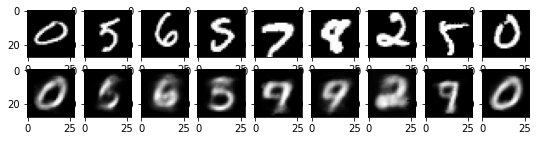

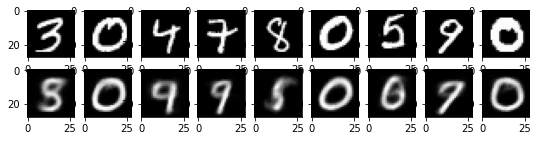

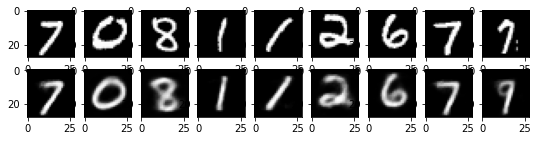

In [ ]:
for k in range(0, n_epoch, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [ ]:
def zero_ones(result):
  one_hot = []
  for lis in result:
    inde = lis.argmax()
    lis[inde] = 1
    lis = lis.tolist()
    one_hot.append(lis)
  return one_hot


In [ ]:
for k in range(0, n_epoch, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1,216,60)
        selfes =sf.encoding_to_selfies(item,vocab_itos=idx_to_symbol,enc_type="one_hot")
        smi_result = sf.decoder(selfes)
        mol = Chem.MolFromSmiles(smi_result)
        plt.imshow(Draw.MolToImage(mol))

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1,216,60)

        recons_selfes =sf.encoding_to_selfies(zero_ones(item),vocab_itos=idx_to_symbol,enc_type="one_hot")
        smi_result = sf.decoder(recons_selfes)
        mol = Chem.MolFromSmiles(smi_result)
        plt.imshow(Draw.MolToImage(mol))

# conv with autoencoder

In [ ]:
class AutoEncoder_CNN(nn.Module):

  def __init__(self):
    super().__init__()
        # N, 1, 28, 28
    self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Tanh()
        )

  def forward(self,x):
    the_encoded = self.encoder(x)
    the_decoded = self.decoder(the_encoded)

    return the_decoded


In [ ]:
model = AutoEncoder_CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)

In [ ]:
n_epoch = 10
outputs =[]
for epoch in range(n_epoch):
  for (img,_) in data_loadr:

    recons = model(img)
    loss = criterion(recons,img)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recons))

Epoch:1, Loss:0.0260
Epoch:2, Loss:0.0180
Epoch:3, Loss:0.0145
Epoch:4, Loss:0.0114
Epoch:5, Loss:0.0125
Epoch:6, Loss:0.0109
Epoch:7, Loss:0.0083
Epoch:8, Loss:0.0102
Epoch:9, Loss:0.0100
Epoch:10, Loss:0.0084


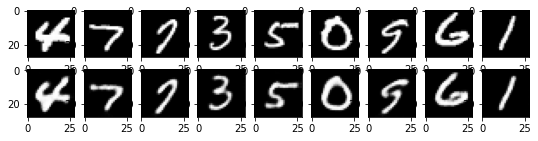

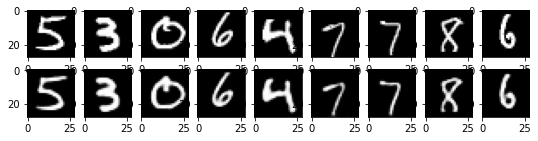

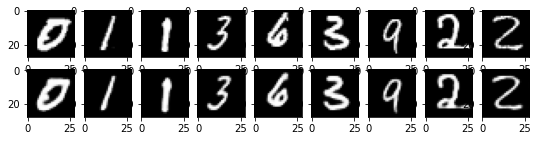

In [ ]:
for k in range(0, n_epoch, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item: 1, 28, 28
        plt.imshow(item[0])